Segmention of Whole Image
========================

This notebook explores using a network trained on windows crooped from the full images to segment the whole images after training. 

This is possible since the network is fully convolutiaonal.

In [3]:
%qtconsole

In [1]:
import sys
import os
from os.path import join, basename
from pathlib import Path
project_root = os.path.abspath('../')
sys.path.append(os.path.abspath('../models/v3/dilations/')) #Add the model source to the path
sys.path.append(os.path.abspath('../src/models/dataloaders'))
sys.path.append(os.path.abspath('../src/'))
import matplotlib.pyplot as plt

from PairedImages import normalize
from models import UNet

from pytorch_utils import util

In [2]:
#Load the trianed network
import torch
Net = UNet()

nets = {'Net': Net}.items()
dir = join(project_root,'models','v3','dilations','saves','noAug_dilations_epoch800')

for key,val in nets:
    state_dict = torch.load(dir + '/' + key + '.net', map_location=lambda storage, loc: storage)
    val.load_state_dict(state_dict)

Inference
---------------
I am not sure of the exact rules for input sizes for UNet, but the pattern I found that holds is the image dimensions must be some mutiple of:

572 * N + (4 * N-1)

where N is an integer >= 0.

Here we load in an image, pad the dimenions to N = 4 for dim 0 and N = 5 for dim 1, and put it though the network. 

The network is run on the CPU, as ~ 12GB of ram are requied to run the whole image. 

In [99]:
%%time
import torch
from skimage import io
from skimage.util import pad
from PairedImages import normalize
import math

data_path = join(project_root, "data/raw/Veins machine learning with Chris/Untraced Veins")
# 1156-1 rough image
image_path = join(data_path,'738-2.jpeg')
image = io.imread(image_path)

pad_width = (
    (182,182), # x
    (146,146),  # y
    (0,0),   # C channel
)
image = pad(image,pad_width,'reflect')

Net = Net.eval().to('cpu')
with torch.no_grad():
    image = torch.from_numpy(image).permute(2,0,1).float()
    image = normalize(image)
    y = Net(image.unsqueeze(0))
    y = y[0,0].numpy()

CPU times: user 2min 55s, sys: 17.6 s, total: 3min 13s
Wall time: 1min 25s


View the segmentation probabilities. 
------------------------------------------------------

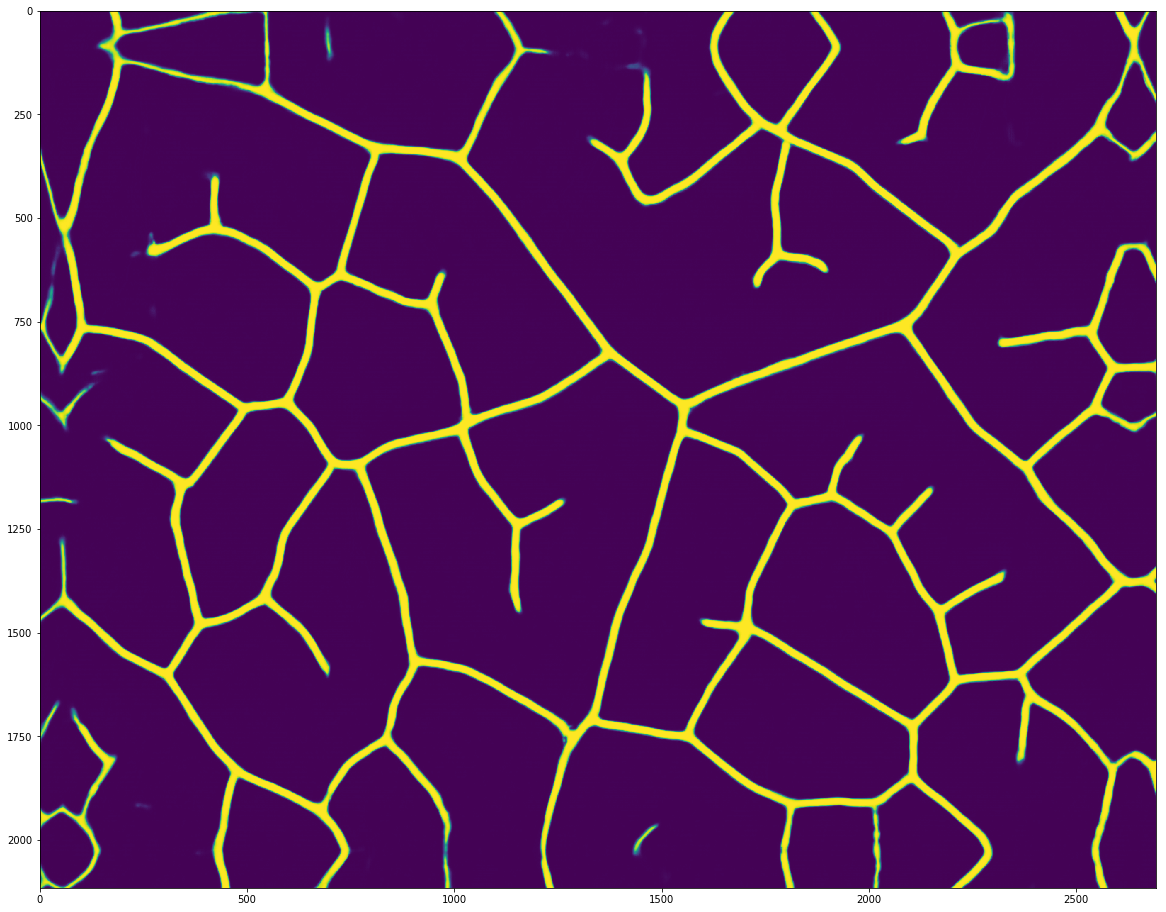

In [109]:
plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()

View the input image
---------------------

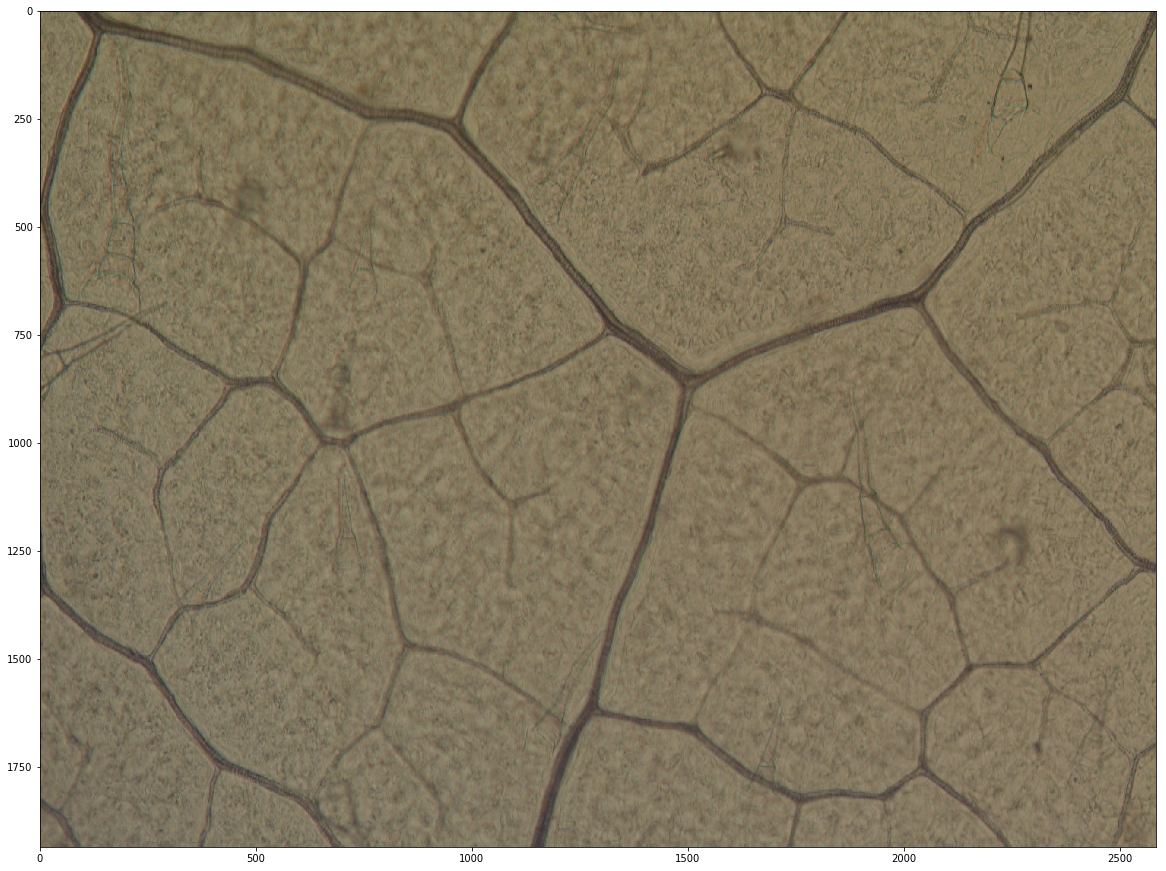

In [107]:
image = io.imread(image_path)
plt.figure(figsize=(20,20))
plt.imshow(image)

Overlay
-------

A probability threshold is chosen to define forground pixels in the network output. This is then overlayed 
on the original input image. 

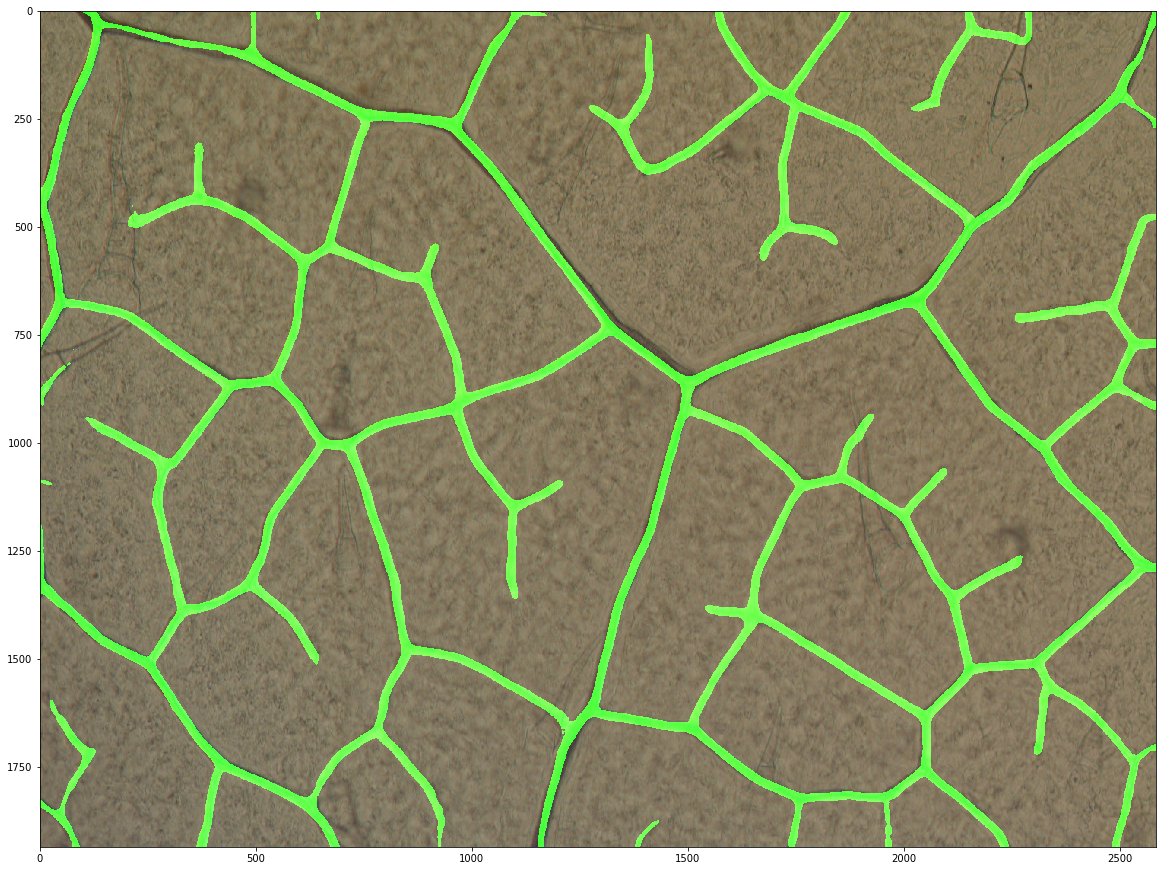

In [108]:
import numpy as np

THRESHOLD = 0.4

overlay = np.copy(image)
x_padding = int((y.shape[0] - overlay.shape[0]) / 2)
y_padding = int((y.shape[1] - overlay.shape[1]) / 2)
seg = y[x_padding:-x_padding,y_padding:-y_padding] > THRESHOLD

overlay[seg,1] = 255

plt.figure(figsize=(20,20))
plt.imshow(overlay)